In [47]:
from google.colab import drive
drive.mount('/content/drive')

from os import listdir
import sys

sys.path.insert(0, "drive/My Drive/Colab Notebooks")


from tme3_etu import *
from models import RegressionLineaire, RegressionRIDGE


root = 'drive/My Drive/' 

%load_ext autoreload
%autoreload 2


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import f1_score


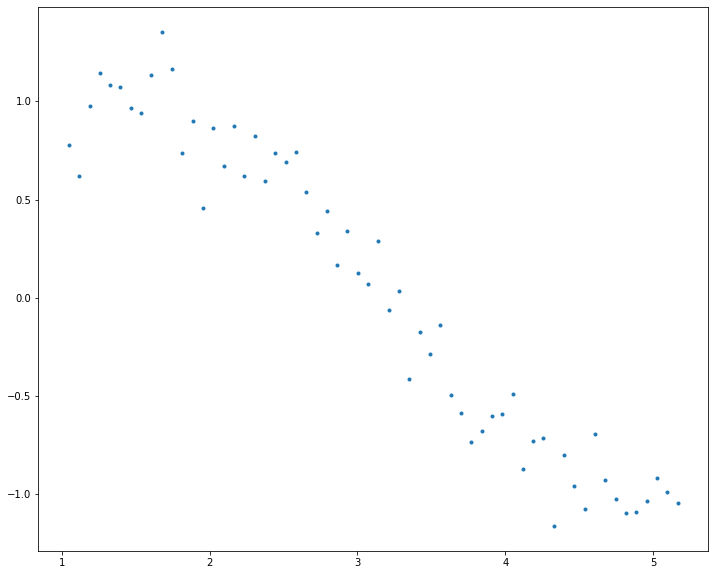

In [48]:
from matplotlib.pylab import rcParams

X_train, y_train = load_usps(f'{root}/data/USPS_train.txt')
X_test, y_test = load_usps(f'{root}/data/USPS_test.txt')


rcParams['figure.figsize'] = 12, 10

x = np.array([i*np.pi/180 for i in range(60,300,4)])
y = np.sin(x) + np.random.normal(0,0.15,len(x))
data = pd.DataFrame(np.column_stack([x,y]),columns=['x','y'])
plt.plot(data['x'],data['y'],'.')
plt.show()

<p>Cela ressemble à une courbe sinusoïdale mais pas exactement à cause du bruit. On nous en servirons comme exemple pour tester différents scénarios. Essayons d'estimer la fonction sinusoïdale en utilisant une régression polynomiale avec des puissances de x de 1 à 15. Ajoutons une colonne pour chaque puissance jusqu'à 15 dans notre cadre de données
</p>

In [49]:
for i in range(2,16):  
    colname = 'x_%d'%i      
    data[colname] = data['x']**i
print(data.head())

    x    y  x_2  x_3  x_4  x_5  x_6  ...  x_9  x_10  x_11  x_12  x_13  x_14  x_15
0   1 0.78  1.1  1.1  1.2  1.3  1.3  ...  1.5   1.6   1.7   1.7   1.8   1.9     2
1 1.1 0.62  1.2  1.4  1.6  1.7  1.9  ...  2.7     3   3.4   3.8   4.2   4.7   5.3
2 1.2 0.97  1.4  1.7    2  2.4  2.8  ...  4.7   5.5   6.6   7.8   9.3    11    13
3 1.3  1.1  1.6    2  2.5  3.1  3.9  ...  7.8   9.8    12    16    19    24    31
4 1.3  1.1  1.8  2.3  3.1  4.1  5.4  ...   13    17    22    30    39    52    69

[5 rows x 16 columns]


<p>Maintenant que nous avons les 15 puissances, faisons 15 modèles de régression linéaire différents, chaque modèle contenant des variables avec des puissances de x allant de 1 au numéro de modèle particulier.</p>

# 1. Régression linéaire

\begin{equation}\operatorname{MSE}\left(f_{\mathbf{w}}, E\right)=\frac{1}{n} \sum_{i=0}^{n}\left(y^{i}-w_{0}-\sum_{j=1}^{d} w_{j} x_{j}^{i}\right)^{2}\end{equation}

Tout d'abord, nous allons définir une fonction générique qui prend en entrée la puissance maximale requise de x et renvoie une liste contenant - [ modèle RSS, intercept, coef_x, coef_x2, ... jusqu'à la puissance entrée ]. Ici, RSS fait référence à la "somme résiduelle des carrés" qui n'est rien d'autre que la somme des carrés des erreurs entre les valeurs prévues et réelles dans l'ensemble des données d'entraînement.


In [0]:
def linear_regression_usps(X_train, y_train, X_test, y_test, prblm):

    class1VSclass2 = prblm

    Xtrain,ytrain, Xtest, ytest =  process_USPS_data(X_train,y_train, X_test, y_test,class1VSclass2,bias=True, scaler=StandardScaler())


    linreg = LinearRegression(normalize=True)
    linreg.fit(Xtrain , ytrain)
    y_pred = np.sign(linreg.predict(Xtest))
    
    f1_test = f1_score(ytest,y_pred)
    ret = [f1_test]
    ret.extend([linreg.intercept_])
    ret.extend(linreg.coef_)
    return ret

col = ['F1','intercept'] + ['coef_w_%d'%i for i in range(0,257)]
ind = ['model_%d'%i for i in range(0,1)]
coef_matrix_simple_usps = pd.DataFrame(index=ind, columns=col)
coef_matrix_simple_usps.iloc[0]  = linear_regression_usps(X_train, y_train, X_test, y_test, (8,'all'))

In [0]:
from sklearn.linear_model import LinearRegression
def linear_regression(data, power, models_to_plot):
    predictors=['x']
    if power>=2:
        predictors.extend(['x_%d'%i for i in range(2,power+1)])
    
    linreg = LinearRegression(normalize=True)
    linreg.fit(data[predictors],data['y'])
    y_pred = linreg.predict(data[predictors])
    
    if power in models_to_plot:
        plt.subplot(models_to_plot[power])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for power: %d'%power)
    
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([linreg.intercept_])
    ret.extend(linreg.coef_)
    return ret

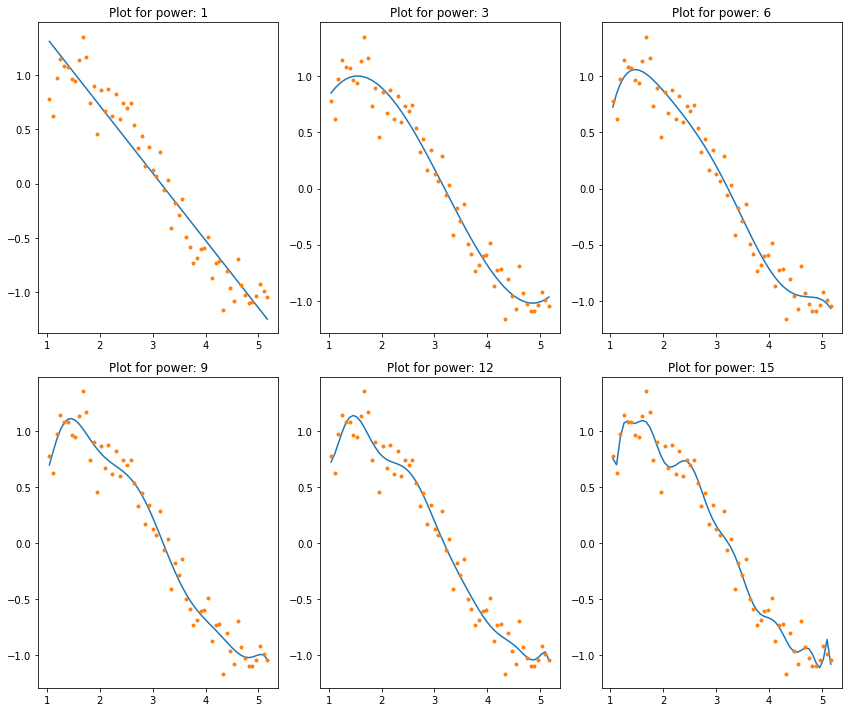

In [52]:
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['model_pow_%d'%i for i in range(1,16)]
coef_matrix_simple = pd.DataFrame(index=ind, columns=col)

models_to_plot = {1:231,3:232,6:233,9:234,12:235,15:236}

for i in range(1,16):
    coef_matrix_simple.iloc[i-1,0:i+2] = linear_regression(data, power=i, models_to_plot=models_to_plot)

On s'attendrait à ce que les modèles de plus en plus complexes correspondent mieux aux données et se traduisent par des valeurs RSS plus faibles. Cela peut être vérifié en examinant les tracés générés pour les 6 modèles.

Cela correspond clairement à notre compréhension initiale. Plus la complexité du modèle augmente, plus les modèles ont tendance à s'adapter à des écarts encore plus faibles dans l'ensemble des données d'entrainement. Bien que cela conduise à un sur-apprentissage.

In [67]:
coef_matrix_simple_usps

,F1,intercept,coef_w_0,coef_w_1,coef_w_2,coef_w_3,coef_w_4,coef_w_5,coef_w_6,coef_w_7,coef_w_8,coef_w_9,coef_w_10,coef_w_11,coef_w_12,coef_w_13,coef_w_14,coef_w_15,coef_w_16,coef_w_17,coef_w_18,coef_w_19,coef_w_20,coef_w_21,coef_w_22,coef_w_23,coef_w_24,coef_w_25,coef_w_26,coef_w_27,coef_w_28,coef_w_29,coef_w_30,coef_w_31,coef_w_32,coef_w_33,coef_w_34,coef_w_35,coef_w_36,coef_w_37,...,coef_w_217,coef_w_218,coef_w_219,coef_w_220,coef_w_221,coef_w_222,coef_w_223,coef_w_224,coef_w_225,coef_w_226,coef_w_227,coef_w_228,coef_w_229,coef_w_230,coef_w_231,coef_w_232,coef_w_233,coef_w_234,coef_w_235,coef_w_236,coef_w_237,coef_w_238,coef_w_239,coef_w_240,coef_w_241,coef_w_242,coef_w_243,coef_w_244,coef_w_245,coef_w_246,coef_w_247,coef_w_248,coef_w_249,coef_w_250,coef_w_251,coef_w_252,coef_w_253,coef_w_254,coef_w_255,coef_w_256
model_0,0.66,-0.85,-0.014,0.0075,0.0023,0.0066,0.016,-0.00047,0.014,-0.015,0.00012,0.00045,-0.00089,0.012,-0.011,0.0098,0.0043,0.016,-0.016,0.015,-0.0067,0.003,-0.023,0.03,-0.031,0.043,-0.023,-0.0066,0.0063,-0.014,0.018,-0.034,0.009,-0.015,0.0048,0.01,0.0055,0.027,0.0074,0.031,...,-0.0022,0.058,-0.0037,-0.03,-0.003,-0.00042,0.0074,0.0011,-0.016,-0.013,0.023,-0.047,0.044,0.035,0.024,0.017,-0.0013,0.0098,0.0018,-0.027,-0.0051,-0.012,0.0056,-0.0041,-0.019,0.022,-0.017,-0.015,0.0051,0.016,0.032,0.032,0.0019,-0.011,0.031,-0.0076,-0.0028,0.0077,-0.003,0


In [0]:
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_simple

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
model_pow_1,3.3,2,-0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_2,3.3,1.9,-0.58,-0.006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_3,1.1,-1.1,3,-1.3,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_4,1.1,-0.27,1.7,-0.53,-0.036,0.014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_5,1,3,-5.1,4.7,-1.9,0.33,-0.021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_6,0.99,-2.8,9.5,-9.7,5.2,-1.6,0.23,-0.014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_7,0.93,19,-56,69,-45,17,-3.5,0.4,-0.019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_8,0.92,43,-1.4e+02,1.8e+02,-1.3e+02,58,-15,2.4,-0.21,0.0077,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_9,0.87,1.7e+02,-6.1e+02,9.6e+02,-8.5e+02,4.6e+02,-1.6e+02,37,-5.2,0.42,-0.015,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_10,0.87,1.4e+02,-4.9e+02,7.3e+02,-6e+02,2.9e+02,-87,15,-0.81,-0.14,0.026,-0.0013,NaN,NaN,NaN,NaN,NaN


Il est clairement évident que la taille des coefficients augmente de manière exponentielle avec l'augmentation de la complexité des modèles. Cela nous permet de comprendre pourquoi il est judicieux de limiter cette augmentation des coefficients pour réduire la complexité des modèles.

Un coefficient élevé  signifie que nous mettons beaucoup l'accent sur cette caractéristique, c'est-à-dire que la caractéristique particulière est un bon prédicteur du résultat. Lorsqu'il devient trop important, l'algorithme commence à modéliser des relations complexes pour estimer le résultat et finit par s'adapter aux données particulières d'entrainement.

# 2. Ridge Regression

La régression Ridge ajoute un facteur de somme des carrés des coefficients dans l'objectif d'optimisation. Ainsi, on optimise ce qui suit:

\begin{equation}L_{2}\left(f_{\mathbf{w}}, E\right)=\operatorname{MSE}\left(f_{\mathbf{w}}, E\right)+\alpha\|\mathbf{w}\|_{2}^{2}\end{equation}

<ul>
    <li>&alpha; = 0:</li>
        <ul>
            <li>L'objectif devient le même que celui de la simple régression linéaire.</li>
            <li>Nous obtiendrons les mêmes coefficients qu'avec la régression linéaire simple.</li>
        </ul>
    <li>&alpha; = &#8734;:</li>
        <ul>
            <li>Les coefficients seront de zéro en raison de la pondération infinie sur le carré des coefficients, tout ce
                qui est inférieur à zéro rendra l'objectif infini.
            </li>
        </ul>
    <li>&alpha; < &alpha; < &#8734;:</li>
        <ul>
            <li>La valeur de &alpha; déterminera le poids accordé aux différentes parties de l'objectif</li>
            <li>Les coefficients se situeront entre 0 et 1 pour la régression linéaire simple.</li>
        </ul>
</ul>


---


<p>Cela donne une idée de l'impact de &alpha; sur l'ampleur des coefficients. Une chose est sûre, toute valeur non nulle donnerait des valeurs inférieures à celles d'une simple régression linéaire.</p>

In [0]:
from sklearn.linear_model import Ridge

def ridge_regression_usps(X_train, y_train, X_test, y_test, prblm,alpha):

    class1VSclass2 = prblm

    Xtrain,ytrain, Xtest, ytest =  process_USPS_data(X_train,y_train, X_test, y_test,class1VSclass2,bias=True, scaler=StandardScaler())


    ridgereg = Ridge(alpha=alpha,normalize=True)
    ridgereg.fit(Xtrain , ytrain)
    y_pred = np.sign(ridgereg.predict(Xtest))
    
    f1_test = f1_score(ytest,y_pred)
    ret = [f1_test]
    ret.extend([ridgereg.intercept_])
    ret.extend(ridgereg.coef_)
    return ret

In [0]:
def ridge_regression(data, predictors, alpha, models_to_plot={}):
    ridgereg = Ridge(alpha=alpha,normalize=True)
    ridgereg.fit(data[predictors],data['y'])
    y_pred = ridgereg.predict(data[predictors])
    
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for alpha: %.3g'%alpha)
    
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([ridgereg.intercept_])
    ret.extend(ridgereg.coef_)
    return ret

<p>

Maintenant, on va analyser le résultat de la régression Ridge pour 10 valeurs différentes de &alpha; allant de 1e-15 à 20. Ces valeurs ont été choisies de manière à ce que nous puissions facilement analyser la tendance avec le changement des valeurs de &alpha;. Celles-ci seraient toutefois différentes d'un cas à l'autre.

</p>

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.69573e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.81609e-17): result may not be accurate.
  overwrite_a=True).T


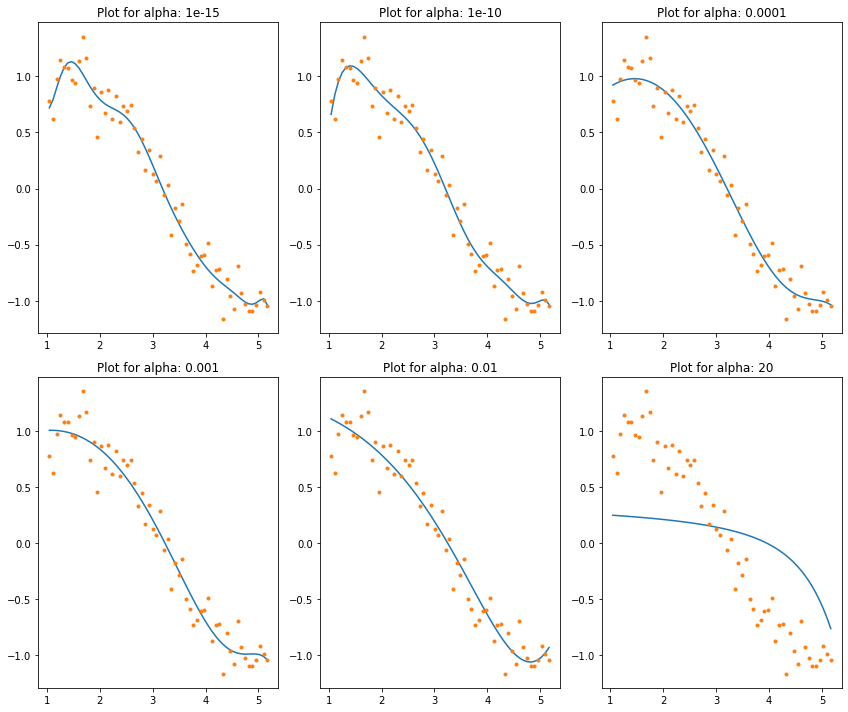

In [86]:
predictors=['x']
predictors.extend(['x_%d'%i for i in range(2,16)])

alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20, 50, 100]

col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['alpha_%.2g'%alpha_ridge[i] for i in range(0,len(alpha_ridge))]
coef_matrix_ridge = pd.DataFrame(index=ind, columns=col)
models_to_plot = {1e-15:231, 1e-10:232, 1e-4:233, 1e-3:234, 1e-2:235, 20:236}



col_usps = ['F1','intercept'] + ['coef_w_%d'%i for i in range(0,257)]
ind_usps = ['alpha_%.2g'%alpha_ridge[i] for i in range(0,len(alpha_ridge))]
coef_matrix_ridge_usps = pd.DataFrame(index=ind_usps, columns=col_usps)

for i in range(len(alpha_ridge)):
  coef_matrix_ridge_usps.iloc[i,]  = ridge_regression_usps(X_train, y_train, X_test, y_test, (8,'all'),alpha_ridge[i])
  coef_matrix_ridge.iloc[i,] = ridge_regression(data, predictors, alpha_ridge[i], models_to_plot)


Comme nous pouvons observer ici, plus la valeur de &alpha; augmente, plus la complexité du modèle diminue. Bien que des valeurs plus élevées de &alpha; réduisent le sur-apprentissage, des valeurs significativement élevées peuvent également entraîner un sous-apprentissage (par exemple, &alpha; = 5). Il convient donc de choisir l'alpha avec discernement. Une technique largement acceptée est la validation croisée.

In [87]:
coef_matrix_ridge_usps

,F1,intercept,coef_w_0,coef_w_1,coef_w_2,coef_w_3,coef_w_4,coef_w_5,coef_w_6,coef_w_7,coef_w_8,coef_w_9,coef_w_10,coef_w_11,coef_w_12,coef_w_13,coef_w_14,coef_w_15,coef_w_16,coef_w_17,coef_w_18,coef_w_19,coef_w_20,coef_w_21,coef_w_22,coef_w_23,coef_w_24,coef_w_25,coef_w_26,coef_w_27,coef_w_28,coef_w_29,coef_w_30,coef_w_31,coef_w_32,coef_w_33,coef_w_34,coef_w_35,coef_w_36,coef_w_37,...,coef_w_217,coef_w_218,coef_w_219,coef_w_220,coef_w_221,coef_w_222,coef_w_223,coef_w_224,coef_w_225,coef_w_226,coef_w_227,coef_w_228,coef_w_229,coef_w_230,coef_w_231,coef_w_232,coef_w_233,coef_w_234,coef_w_235,coef_w_236,coef_w_237,coef_w_238,coef_w_239,coef_w_240,coef_w_241,coef_w_242,coef_w_243,coef_w_244,coef_w_245,coef_w_246,coef_w_247,coef_w_248,coef_w_249,coef_w_250,coef_w_251,coef_w_252,coef_w_253,coef_w_254,coef_w_255,coef_w_256
alpha_1e-15,0.66,-0.85,-0.014,0.0075,0.0023,0.0066,0.016,-0.00047,0.014,-0.015,0.00012,0.00045,-0.00089,0.012,-0.011,0.0098,0.0043,0.016,-0.016,0.015,-0.0067,0.003,-0.023,0.03,-0.031,0.043,-0.023,-0.0066,0.0063,-0.014,0.018,-0.034,0.009,-0.015,0.0048,0.01,0.0055,0.027,0.0074,0.031,...,-0.0022,0.058,-0.0037,-0.03,-0.003,-0.00042,0.0074,0.0011,-0.016,-0.013,0.023,-0.047,0.044,0.035,0.024,0.017,-0.0013,0.0098,0.0018,-0.027,-0.0051,-0.012,0.0056,-0.0041,-0.019,0.022,-0.017,-0.015,0.0051,0.016,0.032,0.032,0.0019,-0.011,0.031,-0.0076,-0.0028,0.0077,-0.003,0
alpha_1e-10,0.66,-0.85,-0.014,0.0075,0.0023,0.0066,0.016,-0.00047,0.014,-0.015,0.00012,0.00045,-0.00089,0.012,-0.011,0.0098,0.0043,0.016,-0.016,0.015,-0.0067,0.003,-0.023,0.03,-0.031,0.043,-0.023,-0.0066,0.0063,-0.014,0.018,-0.034,0.009,-0.015,0.0048,0.01,0.0055,0.027,0.0074,0.031,...,-0.0022,0.058,-0.0037,-0.03,-0.003,-0.00042,0.0074,0.0011,-0.016,-0.013,0.023,-0.047,0.044,0.035,0.024,0.017,-0.0013,0.0098,0.0018,-0.027,-0.0051,-0.012,0.0056,-0.0041,-0.019,0.022,-0.017,-0.015,0.0051,0.016,0.032,0.032,0.0019,-0.011,0.031,-0.0076,-0.0028,0.0077,-0.003,0
alpha_1e-08,0.66,-0.85,-0.014,0.0075,0.0023,0.0066,0.016,-0.00047,0.014,-0.015,0.00012,0.00045,-0.00089,0.012,-0.011,0.0098,0.0043,0.016,-0.016,0.015,-0.0067,0.003,-0.023,0.03,-0.031,0.043,-0.023,-0.0066,0.0063,-0.014,0.018,-0.034,0.009,-0.015,0.0048,0.01,0.0055,0.027,0.0074,0.031,...,-0.0022,0.058,-0.0037,-0.03,-0.003,-0.00042,0.0074,0.0011,-0.016,-0.013,0.023,-0.047,0.044,0.035,0.024,0.017,-0.0013,0.0098,0.0018,-0.027,-0.0051,-0.012,0.0056,-0.0041,-0.019,0.022,-0.017,-0.015,0.0051,0.016,0.032,0.032,0.0019,-0.011,0.031,-0.0076,-0.0028,0.0077,-0.003,0
alpha_0.0001,0.66,-0.85,-0.014,0.0075,0.0023,0.0066,0.016,-0.00044,0.014,-0.015,0.00011,0.00046,-0.00089,0.012,-0.011,0.0097,0.0043,0.016,-0.016,0.015,-0.0067,0.003,-0.023,0.03,-0.03,0.043,-0.023,-0.0066,0.0063,-0.014,0.018,-0.034,0.009,-0.015,0.0048,0.01,0.0055,0.027,0.0075,0.031,...,-0.0022,0.058,-0.0037,-0.029,-0.003,-0.00041,0.0074,0.0011,-0.016,-0.013,0.023,-0.047,0.044,0.035,0.024,0.017,-0.0013,0.0098,0.0017,-0.027,-0.0051,-0.012,0.0056,-0.0041,-0.019,0.022,-0.017,-0.015,0.0051,0.016,0.032,0.032,0.0019,-0.011,0.031,-0.0076,-0.0028,0.0077,-0.003,0
alpha_0.001,0.66,-0.85,-0.014,0.0074,0.0023,0.0068,0.016,-0.00017,0.014,-0.015,8.3e-06,0.00053,-0.00089,0.012,-0.011,0.0094,0.0043,0.016,-0.016,0.015,-0.0066,0.003,-0.023,0.03,-0.03,0.042,-0.022,-0.0068,0.0061,-0.014,0.018,-0.033,0.0088,-0.014,0.0048,0.01,0.0057,0.026,0.0077,0.03,...,-0.002,0.058,-0.0036,-0.029,-0.0031,-0.00035,0.0073,0.001,-0.016,-0.012,0.022,-0.046,0.044,0.035,0.024,0.017,-0.0012,0.01,0.0014,-0.027,-0.0052,-0.012,0.0055,-0.0042,-0.018,0.022,-0.017,-0.015,0.0049,0.016,0.032,0.032,0.0018,-0.011,0.03,-0.0074,-0.0029,0.0076,-0.003,0
alpha_0.01,0.64,-0.85,-0.014,0.0064,0.0027,0.0076,0.014,0.0018,0.012,-0.013,-0.0008,0.0011,-0.0008,0.012,-0.0096,0.0072,0.0045,0.015,-0.015,0.015,-0.0058,0.0025,-0.019,0.026,-0.024,0.036,-0.019,-0.0077,0.0045,-0.013,0.015,-0.028,0.0076,-0.013,0.0043,0.0089,0.0066,0.024,0.0092,0.026,...,-0.00022,0.054,-0.003,-0.027,-0.004,7.8e-06,0.0068,0.00031,-0.015,-0.0099,0.017,-0.04,0.041,0.035,

In [88]:
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_ridge

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
alpha_1e-15,1.2,1.8e+02,-7.1e+02,1.1e+03,-9.8e+02,4.6e+02,-1.1e+02,1.4,4.1,-0.3,-0.14,0.0069,0.0056,0.00011,-0.00035,5.4e-05,-2.6e-06
alpha_1e-10,1.2,-17,40,-32,9.8,-0.28,-0.33,-0.011,0.0099,0.0018,-2e-05,-6.7e-05,-1.3e-05,-1.5e-07,4.4e-07,8.7e-08,-1.5e-08
alpha_1e-08,1.3,-6.7,15,-11,2.7,0.0047,-0.075,-0.0068,0.0014,0.00045,3.9e-05,-7.2e-06,-2.8e-06,-3.1e-07,4.5e-08,2e-08,-2e-09
alpha_0.0001,1.4,0.32,0.84,-0.22,-0.03,-0.0012,0.0004,0.00013,2.4e-05,3.1e-06,2.2e-07,-3.1e-08,-1.6e-08,-3.9e-09,-6.1e-10,-2.9e-11,2.4e-11
alpha_0.001,1.5,0.83,0.29,-0.097,-0.019,-0.0021,-6.6e-05,3.6e-05,1.2e-05,2.7e-06,4.7e-07,6.9e-08,7.3e-09,1.3e-10,-2.2e-10,-8.5e-11,-2.4e-11
alpha_0.01,1.8,1.3,-0.11,-0.048,-0.0089,-0.0012,-0.0001,1.4e-06,3.3e-06,9.9e-07,2.2e-07,4e-08,6.2e-09,7.3e-10,2.8e-11,-2e-11,-9.3e-12
alpha_1,5.2,0.94,-0.13,-0.018,-0.0029,-0.00045,-6.9e-05,-1e-05,-1.4e-06,-1.7e-07,-1.7e-08,-5.4e-10,3.8e-10,1.6e-10,4.4e-11,1.1e-11,2.5e-12
alpha_5,12,0.55,-0.057,-0.0083,-0.0014,-0.00024,-4.1e-05,-7.1e-06,-1.2e-06,-2.1e-07,-3.5e-08,-6e-09,-1e-09,-1.7e-10,-2.8e-11,-4.6e-12,-7.5e-13
alpha_10,17,0.4,-0.036,-0.0054,-0.00094,-0.00017,-3e-05,-5.4e-06,-9.8e-07,-1.8e-07,-3.2e-08,-5.7e-09,-1e-09,-1.9e-10,-3.4e-11,-6.2e-12,-1.1e-12
alpha_20,21,0.28,-0.022,-0.0034,-0.0006,-0.00011,-2e-05,-3.7e-06,-6.9e-07,-1.3e-07,-2.4e-08,-4.4e-09,-8.2e-10,-1.5e-10,-2.9e-11,-5.4e-12,-1e-12


Cela nous permet de tirer immédiatement les conclusions suivantes :


1.   Le RSS augmente avec l'augmentation de &alpha;, la complexité de modèle réduit
2.   Si on compare les coefficients de la première ligne de ce dernier tableau à la dernière ligne du tableau précedent de la régression linéaire simple on peut en deduire qu'un &alpha; aussi petit que 1e-15 nous donne une réduction significative de l'ampleur des coefficients.

3.   Des valeurs &alpha; trés élevées peuvent entraîner un sous-apprentissage important.
4.   Bien que les coefficients soient **très très faibles**, ils ne sont **PAS nuls**.

In [89]:
coef_matrix_ridge.apply(lambda x: sum(x.values==0),axis=1)

alpha_1e-15     0
alpha_1e-10     0
alpha_1e-08     0
alpha_0.0001    0
alpha_0.001     0
alpha_0.01      0
alpha_1         0
alpha_5         0
alpha_10        0
alpha_20        0
alpha_50        0
alpha_1e+02     0
dtype: int64

In [90]:
coef_matrix_ridge_usps.apply(lambda x: sum(x.values==0),axis=1)

alpha_1e-15     1
alpha_1e-10     1
alpha_1e-08     1
alpha_0.0001    1
alpha_0.001     1
alpha_0.01      1
alpha_1         1
alpha_5         1
alpha_10        2
alpha_20        2
alpha_50        2
alpha_1e+02     2
dtype: int64

Cela confirme que les 15 coefficients sont tous supérieurs à zéro (peut être >0 ou < 0).

# 3. Lasso Regression

LASSO est l'abréviation de "Least Absolute Shrinkage and Selection Operator". Il y a deux mots clés ici : "absolu" et "sélection".

La régression LASSO effectue une régularisation L1, c'est-à-dire elle ajoute un facteur de somme de la valeur absolue des coefficients dans la fonction d'érreur. Ainsi, la régression de LASSO optimise ce qui suit :

\begin{equation}L_{1}\left(f_{\mathbf{w}}, E\right)=\operatorname{MSE}\left(f_{\mathbf{w}}, E\right)+\alpha\|\mathbf{w}\|_{1}\end{equation}


Ici, α fonctionne de manière similaire à celle de la Regression Ridge et fournit un compromis entre l'équilibrage du RSS et l'ampleur des coefficients. Comme celui de ridge, α peut prendre différentes valeurs:

1.  α = 0 : Mêmes coefficients avec la régression linéaire simple.
2.  α = &#8734; : Tous les coefficients zéro (même logique qu'auparavant).
3.  0 < α < &#8734; : Les coefficients entre 0 et celui de la régression linéaire simple

In [0]:
from sklearn.linear_model import Lasso


def lasso_regression_usps(X_train, y_train, X_test, y_test, prblm,alpha):

    class1VSclass2 = prblm

    Xtrain,ytrain, Xtest, ytest =  process_USPS_data(X_train,y_train, X_test, y_test,class1VSclass2,bias=True, scaler=StandardScaler())


    lassoreg = Lasso(alpha=alpha,normalize=True, max_iter=1e5)
    lassoreg.fit(Xtrain , ytrain)
    y_pred = np.sign(lassoreg.predict(Xtest))
    
    f1_test = f1_score(ytest,y_pred)
    ret = [f1_test]
    ret.extend([lassoreg.intercept_])
    ret.extend(lassoreg.coef_)
    return ret

In [0]:
def lasso_regression(data, predictors, alpha, models_to_plot={}):
    lassoreg = Lasso(alpha=alpha,normalize=True, max_iter=1e5)
    lassoreg.fit(data[predictors],data['y'])
    y_pred = lassoreg.predict(data[predictors])
    
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for alpha: %.3g'%alpha)
    
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([lassoreg.intercept_])
    ret.extend(lassoreg.coef_)
    return ret

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6850714339830274, tolerance: 0.0036653149317563763
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 442.96104125375626, tolerance: 0.20068347277465173
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6850714328789441, tolerance: 0.0036653149317563763
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

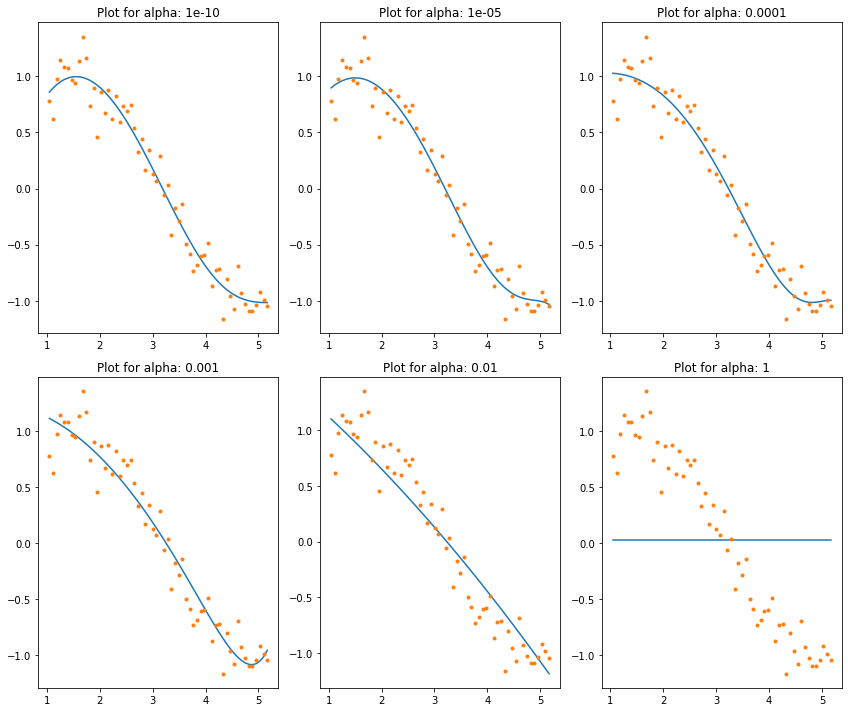

In [99]:
predictors=['x']
predictors.extend(['x_%d'%i for i in range(2,16)])

alpha_lasso = [1e-20, 1e-15, 1e-13, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]

col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['alpha_%.2g'%alpha_lasso[i] for i in range(0,len(alpha_lasso))]
coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)

models_to_plot = {1e-10:231, 1e-5:232,1e-4:233, 1e-3:234, 1e-2:235, 1:236}


col_usps = ['F1','intercept'] + ['coef_w_%d'%i for i in range(0,257)]
ind_usps = ['alpha_%.2g'%alpha_lasso[i] for i in range(0,len(alpha_lasso))]
coef_matrix_lasso_usps = pd.DataFrame(index=ind_usps, columns=col_usps)

for i in range(len(alpha_lasso)):
  coef_matrix_lasso.iloc[i,] = lasso_regression(data, predictors, alpha_lasso[i], models_to_plot)
  coef_matrix_lasso_usps.iloc[i,]  = lasso_regression_usps(X_train, y_train, X_test, y_test, (8,'all'),alpha_lasso[i])


    

<p>
Cela nous indique à nouveau que la complexité du modèle diminue avec l'augmentation α. Mais on peut remarquer que la ligne droite à α=1.
</p>

In [100]:
def color_zeros_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val == 0 else 'white'
    return 'color: %s' % color

pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_lasso_usps.style.applymap(color_zeros_red)

In [101]:
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_lasso.style.applymap(color_zeros_red)

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
alpha_1e-20,1.370143,-0.427206,1.939455,-0.715204,0.029670,0.003995,0.000169,0.000029,0.000011,0.000002,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000
alpha_1e-15,1.370143,-0.427206,1.939455,-0.715204,0.029670,0.003995,0.000169,0.000029,0.000011,0.000002,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000
alpha_1e-13,1.370143,-0.427206,1.939455,-0.715204,0.029670,0.003995,0.000169,0.000029,0.000011,0.000002,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000
alpha_1e-10,1.370143,-0.427202,1.939447,-0.715199,0.029669,0.003995,0.000169,0.000029,0.000011,0.000002,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000
alpha_1e-08,1.370144,-0.426742,1.938724,-0.714763,0.029531,0.004011,0.000172,0.000029,0.000011,0.000002,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
alpha_1e-05,1.382447,-0.008549,1.335824,-0.451373,-0.000000,0.000000,0.000569,0.000155,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
alpha_0.0001,1.519447,0.919863,0.204017,-0.067384,-0.029155,-0.000000,0.000000,0.000000,0.000015,0.000005,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000
alpha_0.001,1.893274,1.239242,-0.000000,-0.117421,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
alpha_0.01,3.163253,1.540558,-0.390053,-0.026752,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000
alpha_1,36.653149,0.031484,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000


<h3>Nous pouvons voir ce qui suit</h3>

1.  Pour les mêmes valeurs de α, les coefficients de la régression LASSO sont beaucoup plus faibles que ceux de la régression Ridge (comparer la ligne 1 des 2 tableaux).

2.  Pour le même α, le lasso a un RSS plus élevé (moins bon ajustement) par rapport à la régression Ridge.

3.  De nombreux coefficients sont nuls, même pour de très petites valeurs α.

La véritable différence par rapport à la réfression Ridge apparaît dans la dernière inférence. Vérifions le nombre de coefficients qui sont nuls dans chaque modèle:

In [0]:
coef_matrix_lasso.apply(lambda x: sum(x.values==0),axis=1)

alpha_1e-15      0
alpha_1e-10      0
alpha_1e-08      0
alpha_1e-05      8
alpha_0.0001     9
alpha_0.001     12
alpha_0.01      14
alpha_1         15
alpha_5         15
alpha_10        15
dtype: int64

In [97]:
coef_matrix_lasso_usps.apply(lambda x: sum(x.values==0),axis=1)

alpha_1e-15       1
alpha_1e-10       1
alpha_1e-08       1
alpha_1e-05      63
alpha_0.0001    176
alpha_0.001     251
alpha_0.01      258
alpha_1         258
alpha_5         258
alpha_10        258
dtype: int64

<p>Nous pouvons observer que même pour une petite valeur de α, un nombre significatif de coefficients sont nuls. Cela explique également l'ajustement de la ligne horizontale pour α=1, c'est un modèle de base ! Ce phénomène de la plupart des coefficients nuls est appelé "sparsity". Le LASSO effectue une sélection de caractéristiques</p>

Cela a des implications vraiment intéressantes sur les cas d'utilisation de la régression LASSO par rapport à celle de la régression Ridge.

# 5. Explications Mathematiques

![alt text](https://raw.githubusercontent.com/YacineAll/Machine-Learning-Project/master/images/matrix_representation.png)

\begin{equation}\hat{y}_{i}=\sum_{j=0}^{M} w_{j} * x_{i j}\end{equation}

# 5.1 Régression Linéaire:

\begin{equation}\operatorname{cost}(W)=R S S(W)=\sum_{i=1}^{N}\left\{y_{i}-\hat{y}_{i}\right\}^{2}=\sum_{i=1}^{N}\left\{y_{i}-\sum_{j=0}^{M} w_{j} x_{i j}\right\}^{2}\end{equation}

<p>Afin de minimiser ce coût, nous utilisons généralement la descente de gradient. Donc on doit calculer le gradient par rapport au poids de cette fonction</p>

\begin{equation}\frac{\partial}{\partial w_{j}} \operatorname{cost}(W)=-2 \sum_{i=1}^{N} x_{i j}\left\{y_{i}-\sum_{k=0}^{M} w_{k} x_{i k}\right\}\end{equation}

<p>Donc pour mettre à jour les poids {$w_{1}$,$w_{2}$,$w_{3}$,...,$w_{m}$} on applique ça:</p>

\begin{equation}w_{j}^{t+1}=w_{j}^{t}+2 \eta \sum_{i=1}^{N} x_{i j}\left\{y_{i}-\sum_{k=0}^{M} w_{k} x_{i k}\right\}\end{equation}

#  5.2 Ridge Regression:

\begin{equation}\begin{aligned}
\operatorname{cost}(W) &=\operatorname{RSS}(W)+\lambda *(\text {sum of squares of weights}) \\
&=\sum_{i=1}^{N}\left\{y_{i}-\sum_{j=0}^{M} w_{j} x_{i j}\right\}+\lambda \sum_{j=0}^{M} w_{j}^{2}
\end{aligned}\end{equation}
<h4>Dans ce cas, le gradient serait :</h4>
\begin{equation}\frac{\partial}{\partial w_{j}} \operatorname{cost}(W)=-2 \sum_{i=1}^{N} x_{i j}\left\{y_{i}-\sum_{k=0}^{M} w_{k} x_{i k}\right\}+2 \lambda w_{j}\end{equation}

<p>Toujours dans la partie régularisation du gradient, seul wj reste et tous les autres deviendraient nuls. La règle de mise à jour correspondante est:</p>

\begin{equation}\begin{array}{c}
w_{j}^{t+1}=w_{j}^{t}-\eta\left[-2 \sum_{i=1}^{N} x_{i j}\left\{y_{i}-\sum_{k=0}^{M} w_{k} * x_{i k}\right\}+2 \lambda w_{j}\right] \\
w_{j}^{t+1}=(1-2 \lambda \eta) w_{j}^{t}+2 \eta \sum_{i=1}^{N} x_{i j}\left\{y_{i}-\sum_{k=0}^{M} w_{k} * x_{i k}\right\}
\end{array}\end{equation}

<p>Nous pouvons voir ici que la deuxième partie est la même que celle de la régression linéaire simple. Ainsi, la régression Ridge équivaut à réduire le poids d'un facteur de (1-2λη) d'abord et à appliquer ensuite la même règle de mise à jour que la régression linéaire simple. Cela permet de comprendre pourquoi les coefficients sont réduits à de petits nombres mais ne deviennent jamais nuls.</p>

# 5.3 3. Lasso Regression:

\begin{equation}\begin{aligned}
\operatorname{cost}(W) &=\operatorname{RSS}(W)+\lambda *(\text {sum of absolute value of weights}) \\
&=\sum_{i=1}^{N}\left\{y_{i}-\sum_{j=0}^{M} w_{j} x_{i j}\right\}+\lambda \sum_{j=0}^{M}\left|w_{j}\right|
\end{aligned}\end{equation}

<h4>Dans ce cas, le gradient n'est pas défini car la fonction absolue n'est pas différentiable à x=0. Ceci peut être illustré comme suit: </h4>

![alt text](https://github.com/YacineAll/Machine-Learning-Project/raw/master/images/lasso.png)

<h5>Nous pouvons voir que les parties à gauche et à droite de 0 sont des lignes droites avec des dérivées définies mais la fonction ne peut pas être différenciée à x=0. Dans ce cas, nous devons utiliser une technique différente appelée descente de coordonnées qui est basée sur le concept de sous-gradients. L'une des descentes de coordonnées suit les algorithmes suivants (c'est également la valeur par défaut dans sklearn):</h5>


\begin{equation}w_{j}=\left[\begin{array}{cc}
g\left(w_{-j}\right)+\frac{\lambda}{2}, & \text { if } g\left(w_{-j}\right)<-\frac{\lambda}{2} \\
0, & \text { if }-\frac{\lambda}{2} \leq g\left(w_{-j}\right) \leq \frac{\lambda}{2} \\
g\left(w_{-j}\right)-\frac{\lambda}{2}, & \text { if } g\left(w_{-j}\right)>\frac{\lambda}{2}
\end{array}\right.\end{equation}

<p>Ici, g(w-j) représente (mais pas exactement) la différence entre le résultat réel et le résultat prévu en considérant tous les résultats SAUF la j ème variable. Si cette valeur est petite, cela signifie que l'algorithme est capable de prédire le résultat assez bien même sans la j ème variable et qu'il peut donc être retiré de l'équation en fixant un coefficient zéro. Cela nous donne une idée de la raison pour laquelle les coefficients deviennent nuls en cas de régression lasso.</p>

<p>En descente de coordonnées, la vérification de la convergence est une autre question. Comme les gradients ne sont pas définis, nous avons besoin d'une autre méthode. De nombreuses alternatives existent, mais la plus simple consiste à vérifier la taille des pas de l'algorithme. Nous pouvons vérifier la différence maximale de poids dans un cycle particulier sur tous les poids des caractéristiques.</p>

<p>Si ce chiffre est inférieur au seuil de tolérance spécifié, l'algo cessera. La convergence n'est pas aussi rapide que la descente du gradient et il se peut que nous devions définir le paramètre "max_iter" si un avertissement apparaît disant que l'algo s'est arrêté avant la convergence.</p>

<p>Résumons, en comparant les coefficients dans les trois cas à l'aide de l'image suivante, qui montre comment les coefficients de Régression Ridge et LASSO se comportent par rapport au cas de régression linéaire simple.</p>

![alt text](https://github.com/YacineAll/Machine-Learning-Project/raw/master/images/compare.png)

<h4>On peut en tirer ces 3 faits: </h4>

1.  Les coefficients de la Régression Ridge sont un facteur réduit des coefficients de régression linéaire simple et n'atteignent donc jamais des valeurs nulles mais des valeurs très faibles.

2. Les coefficients la Régression Lasso deviennent nuls dans une certaine plage et sont réduits par un facteur constant, ce qui explique leur faible amplitude par rapport à la Régression Ridge.




# 6. Conclusion


*   Régression Ridge: Elle comprend toutes (ou aucune) des caractéristiques du modèle. Ainsi, le principal avantage de la régression Ridge est le rétrécissement des coefficients et la réduction de la complexité du modèle.
*   Régression Lasso: En plus du rétrécissement des coefficients, le lasso permet également de sélectionner les caractéristiques. Comme nous l'avons observé précédemment, certains des coefficients deviennent exactement nuls, ce qui équivaut à l'exclusion d'une caractéristique particulière du modèle.

## 6.1 Cas d'utilisation:



*   **Ridge:** est principalement utilisée pour éviter le sur-apprentissage. Comme il comprend toutes les fonctionnalités, il n'est pas très utile en cas de nombre de fonctionnalités exorbitant, disons en millions, car il posera des problèmes de calcul.

*   **Lasso:** il fournit des solutions sparse, il est généralement le modèle de choix pour modéliser les cas où nombre de fonctionnalités sont en millions ou plus. Dans un tel cas, l'obtention d'une solution sparse présente un grand avantage en termes de calcul, car les caractéristiques à coefficients zéro peuvent être simplement ignorées.

## 6.2 Présence de caractéristiques fortement corrélées:



*   **Ridge:** Fonctionne généralement bien même en présence de caractéristiques fortement corrélées, car il les inclut toutes dans le modèle, mais les coefficients sont répartis entre elles en fonction de la corrélation.
*   **Lasso:** Il sélectionne arbitrairement une caractéristique parmi celles qui sont fortement corrélées et réduit les coefficients des autres à zéro. De plus, la variable choisie change de façon aléatoire en fonction de la modification des paramètres du modèle. Cela ne fonctionne généralement pas aussi bien que la régression Ridge.




